## Imports and Configuration

This notebook builds an image classifier that recognizes **cats**, **dogs**, and an **unknown** category for anything that is not a cat or dog.

This section sets up the notebook by importing the required libraries and establishing the base configuration used throughout the workflow.


In [2]:
import json
import random
import shutil
import tarfile
import zipfile
from math import ceil
from pathlib import Path

import numpy as np
import tensorflow as tf

## Combined Pool Paths and Folder Detection

This section detects the main project folder by searching upward until it finds the `Datasets` directory, then defines the paths needed to build the **combined cats and dogs pool**.

It sets up the extracted dataset locations for **freeCodeCamp** and **Microsoft**, creates the `combined_pool/cats` and `combined_pool/dogs` output folders, and prints a readable summary to confirm everything was found correctly.

The combined pool is used to create the **training** and **evaluation** splits later in the notebook.


In [3]:
from pathlib import Path

# Start from the notebook's current working directory.
starting_directory = Path.cwd().resolve()

# Walk upward until the folder that contains "Datasets" is found.
base_project_directory = None
for candidate_directory in [starting_directory] + list(starting_directory.parents):
    if (candidate_directory / "Datasets").exists():
        base_project_directory = candidate_directory
        break

# Stop early if the expected project structure is not found.
if base_project_directory is None:
    raise RuntimeError(f"I could not find a 'Datasets' folder when searching upward from: {starting_directory}")

datasets_directory = base_project_directory / "Datasets"
extracted_datasets_directory = datasets_directory / "Extracted"
prepared_datasets_directory = datasets_directory / "Prepared"

# Define where the combined pool will be written.
combined_pool_directory = prepared_datasets_directory / "combined_pool"
combined_pool_cats_directory = combined_pool_directory / "cats"
combined_pool_dogs_directory = combined_pool_directory / "dogs"

# Create the combined pool folders if they do not exist yet.
combined_pool_cats_directory.mkdir(parents=True, exist_ok=True)
combined_pool_dogs_directory.mkdir(parents=True, exist_ok=True)

# Define the extracted dataset folders that feed into the combined pool.
extracted_freecodecamp_directory = extracted_datasets_directory / "freecodecamp"
extracted_microsoft_directory = extracted_datasets_directory / "microsoft"

# Print a quick, readable status summary so you can confirm paths are correct.
print(f"Project folder detected: {base_project_directory}")
print(f"Found extracted datasets folder: {extracted_datasets_directory.exists()}  ->  {extracted_datasets_directory}")

if extracted_datasets_directory.exists():
    extracted_subfolder_names = sorted([path.name for path in extracted_datasets_directory.iterdir() if path.is_dir()])
    print("Extracted dataset folders available:", ", ".join(extracted_subfolder_names) if extracted_subfolder_names else "(none)")

print(f"freeCodeCamp extracted folder found: {extracted_freecodecamp_directory.exists()}  ->  {extracted_freecodecamp_directory}")
print(f"Microsoft extracted folder found:   {extracted_microsoft_directory.exists()}  ->  {extracted_microsoft_directory}")
print(f"Combined pool output folder ready:  {combined_pool_directory.exists()}  ->  {combined_pool_directory}")


Project folder detected: C:\Users\223023795\Desktop\Cat and Dog Classifier
Found extracted datasets folder: True  ->  C:\Users\223023795\Desktop\Cat and Dog Classifier\Datasets\Extracted
Extracted dataset folders available: coco_annotations, coco_val2017, freecodecamp, microsoft, oxford, places365_val_256
freeCodeCamp extracted folder found: True  ->  C:\Users\223023795\Desktop\Cat and Dog Classifier\Datasets\Extracted\freecodecamp
Microsoft extracted folder found:   True  ->  C:\Users\223023795\Desktop\Cat and Dog Classifier\Datasets\Extracted\microsoft
Combined pool output folder ready:  True  ->  C:\Users\223023795\Desktop\Cat and Dog Classifier\Datasets\Prepared\combined_pool


## Build Combined Cats and Dogs Pool

This section combines cat and dog images from the extracted **freeCodeCamp** and **Microsoft** datasets into a single pooled folder structure:

- `combined_pool/cats`
- `combined_pool/dogs`

It searches the extracted folders for image files, skips corrupted files by decoding them with TensorFlow, then copies the readable images into the combined pool using unique filenames to avoid collisions. A short summary is printed showing how many files were copied and skipped.


In [4]:
allowed_image_extensions = (".jpg", ".jpeg", ".png")
skip_unreadable_images = True
random_seed = 42


def list_image_files_recursively(root_directory: Path) -> list[Path]:
    # Collect all image files under a directory.
    return [
        file_path
        for file_path in root_directory.rglob("*")
        if file_path.is_file() and file_path.suffix.lower() in allowed_image_extensions
    ]


def is_image_file_readable(image_file_path: Path) -> bool:
    # Try decoding the image with TensorFlow to catch corrupted files.
    try:
        image_bytes = tf.io.read_file(str(image_file_path))
        file_suffix = image_file_path.suffix.lower()

        if file_suffix in (".jpg", ".jpeg"):
            tf.io.decode_jpeg(image_bytes, channels=3)
            return True

        if file_suffix == ".png":
            tf.io.decode_png(image_bytes, channels=3)
            return True

        return False
    except Exception:
        return False


def clear_directory_contents(directory_path: Path):
    # Remove everything inside the directory, keep the directory itself.
    if not directory_path.exists():
        return

    for child_path in directory_path.iterdir():
        if child_path.is_dir():
            shutil.rmtree(child_path)
        else:
            child_path.unlink()


def find_first_existing_directory(candidate_directories: list[Path]) -> Path | None:
    # Return the first directory that exists from a list of candidates.
    for directory_path in candidate_directories:
        if directory_path.exists() and directory_path.is_dir():
            return directory_path
    return None


def resolve_freecodecamp_cats_dogs_directories() -> tuple[Path, Path]:
    # Find cats and dogs folders inside the extracted freeCodeCamp directory.
    candidate_cats_directories = [
        extracted_freecodecamp_directory / "cats",
        extracted_freecodecamp_directory / "Cats",
        extracted_freecodecamp_directory / "cat",
        extracted_freecodecamp_directory / "Cat",
    ]
    candidate_dogs_directories = [
        extracted_freecodecamp_directory / "dogs",
        extracted_freecodecamp_directory / "Dogs",
        extracted_freecodecamp_directory / "dog",
        extracted_freecodecamp_directory / "Dog",
    ]

    cats_directory = find_first_existing_directory(candidate_cats_directories)
    dogs_directory = find_first_existing_directory(candidate_dogs_directories)

    if cats_directory and dogs_directory:
        return cats_directory, dogs_directory

    all_directories = [path for path in extracted_freecodecamp_directory.rglob("*") if path.is_dir()]
    cats_directory = next((path for path in all_directories if path.name.lower() in {"cats", "cat"}), None)
    dogs_directory = next((path for path in all_directories if path.name.lower() in {"dogs", "dog"}), None)

    if not cats_directory or not dogs_directory:
        raise RuntimeError("Could not locate freeCodeCamp cats and dogs directories after extraction.")

    return cats_directory, dogs_directory


def resolve_microsoft_cats_dogs_directories() -> tuple[Path, Path]:
    # Find PetImages/Cat and PetImages/Dog inside the extracted Microsoft dataset.
    pet_images_directory = find_first_existing_directory(
        [
            extracted_microsoft_directory / "PetImages",
            extracted_microsoft_directory / "kagglecatsanddogs_5340" / "PetImages",
        ]
    )

    if not pet_images_directory:
        pet_images_directory = next(
            (path for path in extracted_microsoft_directory.rglob("PetImages") if path.is_dir()),
            None,
        )

    if not pet_images_directory:
        raise RuntimeError("Could not locate Microsoft 'PetImages' directory after extraction.")

    cats_directory = pet_images_directory / "Cat"
    dogs_directory = pet_images_directory / "Dog"

    if not cats_directory.exists() or not dogs_directory.exists():
        raise RuntimeError("Could not locate Microsoft Cat and Dog folders inside PetImages.")

    return cats_directory, dogs_directory


def copy_images_into_pool(
    source_image_paths: list[Path],
    destination_directory: Path,
    filename_prefix: str,
    random_number_generator: random.Random,
) -> tuple[int, int]:
    # Copy images into the pool using unique names, optionally skipping unreadable files.
    destination_directory.mkdir(parents=True, exist_ok=True)

    copied_count = 0
    skipped_count = 0

    for image_file_path in source_image_paths:
        if skip_unreadable_images and not is_image_file_readable(image_file_path):
            skipped_count += 1
            continue

        unique_suffix = f"{random_number_generator.getrandbits(64):016x}"
        destination_file_name = f"{filename_prefix}_{unique_suffix}{image_file_path.suffix.lower()}"
        destination_file_path = destination_directory / destination_file_name

        shutil.copy2(image_file_path, destination_file_path)
        copied_count += 1

    return copied_count, skipped_count


def rebuild_cat_dog_combined_pool():
    # Build combined_pool/cats and combined_pool/dogs from freeCodeCamp and Microsoft extracts.
    random_number_generator = random.Random(random_seed)

    clear_directory_contents(combined_pool_cats_directory)
    clear_directory_contents(combined_pool_dogs_directory)

    freecodecamp_cats_directory, freecodecamp_dogs_directory = resolve_freecodecamp_cats_dogs_directories()
    microsoft_cats_directory, microsoft_dogs_directory = resolve_microsoft_cats_dogs_directories()

    freecodecamp_cat_images = list_image_files_recursively(freecodecamp_cats_directory)
    freecodecamp_dog_images = list_image_files_recursively(freecodecamp_dogs_directory)

    microsoft_cat_images = list_image_files_recursively(microsoft_cats_directory)
    microsoft_dog_images = list_image_files_recursively(microsoft_dogs_directory)

    freecodecamp_cat_copied, freecodecamp_cat_skipped = copy_images_into_pool(
        source_image_paths=freecodecamp_cat_images,
        destination_directory=combined_pool_cats_directory,
        filename_prefix="freecodecamp_cat",
        random_number_generator=random_number_generator,
    )
    freecodecamp_dog_copied, freecodecamp_dog_skipped = copy_images_into_pool(
        source_image_paths=freecodecamp_dog_images,
        destination_directory=combined_pool_dogs_directory,
        filename_prefix="freecodecamp_dog",
        random_number_generator=random_number_generator,
    )

    microsoft_cat_copied, microsoft_cat_skipped = copy_images_into_pool(
        source_image_paths=microsoft_cat_images,
        destination_directory=combined_pool_cats_directory,
        filename_prefix="microsoft_cat",
        random_number_generator=random_number_generator,
    )
    microsoft_dog_copied, microsoft_dog_skipped = copy_images_into_pool(
        source_image_paths=microsoft_dog_images,
        destination_directory=combined_pool_dogs_directory,
        filename_prefix="microsoft_dog",
        random_number_generator=random_number_generator,
    )

    print("Combined pool cats copied:", freecodecamp_cat_copied + microsoft_cat_copied)
    print("Combined pool dogs copied:", freecodecamp_dog_copied + microsoft_dog_copied)
    print("Skipped unreadable cats:", freecodecamp_cat_skipped + microsoft_cat_skipped)
    print("Skipped unreadable dogs:", freecodecamp_dog_skipped + microsoft_dog_skipped)


rebuild_cat_dog_combined_pool()


Combined pool cats copied: 13427
Combined pool dogs copied: 13397
Skipped unreadable cats: 73
Skipped unreadable dogs: 103


## Build Unknown Pool and Unknown Test Sets

This section prepares the **Unknown** class in two ways:

- **Places365** is split into:
  - an **unknown pool** saved in `combined_pool/unknown` (used later for training and evaluation splits), and
  - a **Places-only unknown test set** saved in `Datasets/Test/unknown_test/unknown_places`.

- **COCO (val2017)** is used to build a separate **COCO-only unknown test set** saved in `Datasets/Test/unknown_test/unknown_coco`, filtering out any images that contain animals (including cats and dogs) using the COCO annotations file.

All copied images are checked for readability by decoding them with TensorFlow, unreadable files are skipped, and the cell prints a summary of what was copied and skipped.


In [5]:
unknown_places_test_ratio = 0.10

test_datasets_directory = datasets_directory / "Test"
unknown_test_directory = test_datasets_directory / "unknown_test"
unknown_places_test_directory = unknown_test_directory / "unknown_places"
unknown_coco_test_directory = unknown_test_directory / "unknown_coco"

# Confirm the expected test folders exist.
if not unknown_places_test_directory.exists():
    raise RuntimeError(f"Missing folder: {unknown_places_test_directory}")

if not unknown_coco_test_directory.exists():
    raise RuntimeError(f"Missing folder: {unknown_coco_test_directory}")

# Source folders from extracted datasets.
extracted_places365_directory = extracted_datasets_directory / "places365_val_256"
extracted_coco_validation_images_directory = extracted_datasets_directory / "coco_val2017"
extracted_coco_annotations_directory = extracted_datasets_directory / "coco_annotations"

# Unknown pool used later for training and evaluation splits.
combined_pool_unknown_directory = combined_pool_directory / "unknown"
combined_pool_unknown_directory.mkdir(parents=True, exist_ok=True)


def find_coco_validation_images_directory() -> Path:
    candidate_val2017_directory = extracted_coco_validation_images_directory / "val2017"
    if candidate_val2017_directory.exists():
        return candidate_val2017_directory

    discovered_val2017_directory = next(
        (path for path in extracted_coco_validation_images_directory.rglob("val2017") if path.is_dir()),
        None,
    )
    if not discovered_val2017_directory:
        raise RuntimeError("Could not locate COCO val2017 images directory after extraction.")
    return discovered_val2017_directory


def find_coco_instances_validation_json() -> Path:
    candidate_json_path = extracted_coco_annotations_directory / "annotations" / "instances_val2017.json"
    if candidate_json_path.exists():
        return candidate_json_path

    discovered_json_path = next(
        (path for path in extracted_coco_annotations_directory.rglob("instances_val2017.json") if path.is_file()),
        None,
    )
    if not discovered_json_path:
        raise RuntimeError("Could not locate instances_val2017.json after extracting COCO annotations.")
    return discovered_json_path


def rebuild_unknown_from_places():
    # Split Places365 into: (1) training/eval unknown pool, (2) Places-only unknown test set.
    random_number_generator = random.Random(random_seed)

    clear_directory_contents(combined_pool_unknown_directory)
    clear_directory_contents(unknown_places_test_directory)

    places_image_paths = list_image_files_recursively(extracted_places365_directory)
    if not places_image_paths:
        raise RuntimeError("No Places365 images were found after extraction.")

    random_number_generator.shuffle(places_image_paths)

    places_test_image_count = ceil(len(places_image_paths) * unknown_places_test_ratio)
    places_test_image_paths = places_image_paths[:places_test_image_count]
    places_pool_image_paths = places_image_paths[places_test_image_count:]

    test_copied_count, test_skipped_count = copy_images_into_pool(
        source_image_paths=places_test_image_paths,
        destination_directory=unknown_places_test_directory,
        filename_prefix="places_test_unknown",
        random_number_generator=random_number_generator,
    )
    pool_copied_count, pool_skipped_count = copy_images_into_pool(
        source_image_paths=places_pool_image_paths,
        destination_directory=combined_pool_unknown_directory,
        filename_prefix="places_pool_unknown",
        random_number_generator=random_number_generator,
    )

    total_skipped_count = test_skipped_count + pool_skipped_count

    print("Places365 unknown results")
    print(f"  Total images found: {len(places_image_paths)}")
    print(f"  Skipped unreadable: {total_skipped_count}")
    print(f"  Copied to test (unknown_places): {test_copied_count}")
    print(f"  Copied to pool (combined_pool/unknown): {pool_copied_count}")
    print("")


def rebuild_unknown_coco_test_filtered():
    # Build a COCO-only unknown test set by excluding images that contain animals (including cats and dogs).
    random_number_generator = random.Random(random_seed)

    clear_directory_contents(unknown_coco_test_directory)

    coco_images_directory = find_coco_validation_images_directory()
    coco_instances_json_path = find_coco_instances_validation_json()

    with open(coco_instances_json_path, "r", encoding="utf-8") as json_file:
        coco_instances = json.load(json_file)

    excluded_category_ids = {
        16,  # bird
        17,  # cat
        18,  # dog
        19,  # horse
        20,  # sheep
        21,  # cow
        22,  # elephant
        23,  # bear
        24,  # zebra
        25,  # giraffe
    }

    annotations_by_image_id: dict[int, set[int]] = {}
    for annotation in coco_instances.get("annotations", []):
        image_id = int(annotation["image_id"])
        category_id = int(annotation["category_id"])
        if image_id not in annotations_by_image_id:
            annotations_by_image_id[image_id] = set()
        annotations_by_image_id[image_id].add(category_id)

    copied_count = 0
    skipped_unreadable_count = 0
    missing_file_count = 0
    excluded_animal_count = 0
    total_checked_count = 0

    for image_item in coco_instances.get("images", []):
        image_id = int(image_item["id"])
        file_name = image_item["file_name"]
        image_path = coco_images_directory / file_name

        if not image_path.exists():
            missing_file_count += 1
            continue

        total_checked_count += 1

        category_ids_in_image = annotations_by_image_id.get(image_id, set())
        if category_ids_in_image.intersection(excluded_category_ids):
            excluded_animal_count += 1
            continue

        if skip_unreadable_images and not is_image_file_readable(image_path):
            skipped_unreadable_count += 1
            continue

        unique_suffix = f"{random_number_generator.getrandbits(64):016x}"
        destination_file_name = f"coco_test_unknown_{unique_suffix}{image_path.suffix.lower()}"
        destination_file_path = unknown_coco_test_directory / destination_file_name
        shutil.copy2(image_path, destination_file_path)
        copied_count += 1

    print("COCO unknown test results")
    print(f"  Images checked: {total_checked_count}")
    print(f"  Excluded (animal present): {excluded_animal_count}")
    print(f"  Missing files skipped: {missing_file_count}")
    print(f"  Skipped unreadable: {skipped_unreadable_count}")
    print(f"  Copied to test (unknown_coco): {copied_count}")


rebuild_unknown_from_places()
rebuild_unknown_coco_test_filtered()


Places365 unknown results
  Total images found: 36500
  Skipped unreadable: 0
  Copied to test (unknown_places): 3650
  Copied to pool (combined_pool/unknown): 32850

COCO unknown test results
  Images checked: 5000
  Excluded (animal present): 1016
  Missing files skipped: 0
  Skipped unreadable: 0
  Copied to test (unknown_coco): 3984


## Build Oxford Cats and Dogs Test Set

This section creates a **cats vs dogs** test set using **all extracted Oxford images**.

It reads every image in the Oxford `images` folder, infers whether it is a cat or dog from the breed name in the filename, then copies the files into:

- `Datasets/Test/oxford_test/cats`
- `Datasets/Test/oxford_test/dogs`

Unreadable images are skipped using the TensorFlow decoding check, and a short summary is printed at the end.


In [6]:
# Oxford test output folders (must already exist).
test_datasets_directory = datasets_directory / "Test"
oxford_test_directory = test_datasets_directory / "oxford_test"
oxford_test_cats_directory = oxford_test_directory / "cats"
oxford_test_dogs_directory = oxford_test_directory / "dogs"

if not oxford_test_cats_directory.exists():
    raise RuntimeError(f"Missing folder: {oxford_test_cats_directory}")

if not oxford_test_dogs_directory.exists():
    raise RuntimeError(f"Missing folder: {oxford_test_dogs_directory}")

# Oxford extracted dataset location.
extracted_oxford_directory = extracted_datasets_directory / "oxford"


def find_oxford_images_directory() -> Path:
    # Locate the Oxford images folder, even if extraction created nested folders.
    candidate_images_directory = extracted_oxford_directory / "images"
    if candidate_images_directory.exists():
        return candidate_images_directory

    discovered_images_directory = next(
        (path for path in extracted_oxford_directory.rglob("images") if path.is_dir()),
        None,
    )
    if not discovered_images_directory:
        raise RuntimeError("Could not locate Oxford images directory after extraction.")
    return discovered_images_directory


def extract_oxford_breed_name_from_filename(image_file_path: Path) -> str | None:
    # Oxford filename format is usually BreedName_123.jpg, breed can contain underscores.
    file_stem = image_file_path.stem
    stem_parts = file_stem.split("_")
    if len(stem_parts) < 2:
        return None

    last_part = stem_parts[-1]
    if not last_part.isdigit():
        return None

    breed_name = "_".join(stem_parts[:-1]).strip()
    return breed_name if breed_name else None


def rebuild_oxford_all_images_test_set():
    random_number_generator = random.Random(random_seed)

    # These are the 12 cat breeds in Oxford-IIIT Pet. Everything else is a dog breed.
    cat_breed_names = {
        "abyssinian",
        "bengal",
        "birman",
        "bombay",
        "british_shorthair",
        "egyptian_mau",
        "maine_coon",
        "persian",
        "ragdoll",
        "russian_blue",
        "siamese",
        "sphynx",
    }

    clear_directory_contents(oxford_test_cats_directory)
    clear_directory_contents(oxford_test_dogs_directory)

    oxford_images_directory = find_oxford_images_directory()
    oxford_image_paths = list_image_files_recursively(oxford_images_directory)
    if not oxford_image_paths:
        raise RuntimeError("No Oxford images were found after extraction.")

    cat_image_paths: list[Path] = []
    dog_image_paths: list[Path] = []
    unrecognized_filename_count = 0

    for image_file_path in oxford_image_paths:
        breed_name = extract_oxford_breed_name_from_filename(image_file_path)
        if not breed_name:
            unrecognized_filename_count += 1
            continue

        if breed_name.lower() in cat_breed_names:
            cat_image_paths.append(image_file_path)
        else:
            dog_image_paths.append(image_file_path)

    cat_copied_count, cat_skipped_unreadable_count = copy_images_into_pool(
        source_image_paths=cat_image_paths,
        destination_directory=oxford_test_cats_directory,
        filename_prefix="oxford_test_cat",
        random_number_generator=random_number_generator,
    )
    dog_copied_count, dog_skipped_unreadable_count = copy_images_into_pool(
        source_image_paths=dog_image_paths,
        destination_directory=oxford_test_dogs_directory,
        filename_prefix="oxford_test_dog",
        random_number_generator=random_number_generator,
    )

    total_skipped_unreadable_count = cat_skipped_unreadable_count + dog_skipped_unreadable_count

    print("Oxford cats and dogs test results")
    print(f"  Total images found: {len(oxford_image_paths)}")
    print(f"  Unrecognized filenames skipped: {unrecognized_filename_count}")
    print(f"  Skipped unreadable: {total_skipped_unreadable_count}")
    print(f"  Copied to test (oxford_test/cats): {cat_copied_count}")
    print(f"  Copied to test (oxford_test/dogs): {dog_copied_count}")


rebuild_oxford_all_images_test_set()


Oxford cats and dogs test results
  Total images found: 7390
  Unrecognized filenames skipped: 0
  Skipped unreadable: 0
  Copied to test (oxford_test/cats): 2400
  Copied to test (oxford_test/dogs): 4990


## Create Train and Validation Splits

This section creates the **training** and **validation** datasets from the `combined_pool` folders.

It shuffles each class (`cats`, `dogs`, `unknown`) in a reproducible way, applies the split ratio (`training_split_ratio`), then copies the images into:

- `Datasets/Splits/train_split/<class>`
- `Datasets/Splits/validation_split/<class>`

Unreadable images are skipped using the TensorFlow decoding check, and a summary of copied and skipped files is printed.


In [7]:
training_split_ratio = 0.80

splits_directory = datasets_directory / "Splits"

train_split_directory = splits_directory / "train_split"
validation_split_directory = splits_directory / "validation_split"

train_split_cats_directory = train_split_directory / "cats"
train_split_dogs_directory = train_split_directory / "dogs"
train_split_unknown_directory = train_split_directory / "unknown"

validation_split_cats_directory = validation_split_directory / "cats"
validation_split_dogs_directory = validation_split_directory / "dogs"
validation_split_unknown_directory = validation_split_directory / "unknown"

train_split_cats_directory.mkdir(parents=True, exist_ok=True)
train_split_dogs_directory.mkdir(parents=True, exist_ok=True)
train_split_unknown_directory.mkdir(parents=True, exist_ok=True)

validation_split_cats_directory.mkdir(parents=True, exist_ok=True)
validation_split_dogs_directory.mkdir(parents=True, exist_ok=True)
validation_split_unknown_directory.mkdir(parents=True, exist_ok=True)


def split_class_directory_into_train_and_validation(
    class_name: str,
    combined_pool_class_directory: Path,
    train_split_class_directory: Path,
    validation_split_class_directory: Path,
) -> tuple[int, int, int, int]:
    # Deterministic shuffle per class, so the split is reproducible.
    random_number_generator = random.Random(f"{random_seed}_{class_name}")

    clear_directory_contents(train_split_class_directory)
    clear_directory_contents(validation_split_class_directory)

    class_image_paths = list_image_files_recursively(combined_pool_class_directory)
    if not class_image_paths:
        raise RuntimeError(f"No images found in combined pool for class: {class_name}")

    unreadable_skipped_count = 0
    readable_image_paths: list[Path] = []

    # Filter out corrupted images before splitting.
    for image_path in class_image_paths:
        if skip_unreadable_images and not is_image_file_readable(image_path):
            unreadable_skipped_count += 1
            continue
        readable_image_paths.append(image_path)

    if not readable_image_paths:
        raise RuntimeError(f"All images were unreadable in combined pool for class: {class_name}")

    random_number_generator.shuffle(readable_image_paths)

    train_image_count = int(len(readable_image_paths) * training_split_ratio)
    train_image_paths = readable_image_paths[:train_image_count]
    validation_image_paths = readable_image_paths[train_image_count:]

    for image_path in train_image_paths:
        shutil.copy2(image_path, train_split_class_directory / image_path.name)

    for image_path in validation_image_paths:
        shutil.copy2(image_path, validation_split_class_directory / image_path.name)

    total_readable_count = len(readable_image_paths)
    return total_readable_count, unreadable_skipped_count, len(train_image_paths), len(validation_image_paths)


cats_total, cats_skipped, cats_train, cats_validation = split_class_directory_into_train_and_validation(
    class_name="cats",
    combined_pool_class_directory=combined_pool_cats_directory,
    train_split_class_directory=train_split_cats_directory,
    validation_split_class_directory=validation_split_cats_directory,
)

dogs_total, dogs_skipped, dogs_train, dogs_validation = split_class_directory_into_train_and_validation(
    class_name="dogs",
    combined_pool_class_directory=combined_pool_dogs_directory,
    train_split_class_directory=train_split_dogs_directory,
    validation_split_class_directory=validation_split_dogs_directory,
)

unknown_total, unknown_skipped, unknown_train, unknown_validation = split_class_directory_into_train_and_validation(
    class_name="unknown",
    combined_pool_class_directory=combined_pool_unknown_directory,
    train_split_class_directory=train_split_unknown_directory,
    validation_split_class_directory=validation_split_unknown_directory,
)

print("Train and validation split results")
print(f"  Training split ratio: {training_split_ratio}")
print(f"  Cats, total readable: {cats_total}")
print(f"  Skipped unreadable: {cats_skipped}")
print(f"  Copied to train (cats): {cats_train}")
print(f"  Copied to validation (cats): {cats_validation}")
print(f"  Dogs, total readable: {dogs_total}")
print(f"  Skipped unreadable: {dogs_skipped}")
print(f"  Copied to train (dogs): {dogs_train}")
print(f"  Copied to validation (dogs): {dogs_validation}")
print(f"  Unknown, total readable: {unknown_total}")
print(f"  Skipped unreadable: {unknown_skipped}")
print(f"  Copied to train (unknown): {unknown_train}")
print(f"  Copied to validation (unknown): {unknown_validation}")
print("")
print(f"Train split folder: {train_split_directory}")
print(f"Validation split folder: {validation_split_directory}")


Train and validation split results
  Training split ratio: 0.8
  Cats, total readable: 13427
  Skipped unreadable: 0
  Copied to train (cats): 10741
  Copied to validation (cats): 2686
  Dogs, total readable: 13397
  Skipped unreadable: 0
  Copied to train (dogs): 10717
  Copied to validation (dogs): 2680
  Unknown, total readable: 32850
  Skipped unreadable: 0
  Copied to train (unknown): 26280
  Copied to validation (unknown): 6570

Train split folder: C:\Users\223023795\Desktop\Cat and Dog Classifier\Datasets\Splits\train_split
Validation split folder: C:\Users\223023795\Desktop\Cat and Dog Classifier\Datasets\Splits\validation_split


## Create Training and Validation Data Generators

This section sets up the image input pipeline for model training.

It loads images from `Datasets/Splits/train_split` and `Datasets/Splits/validation_split`, applies data augmentation to the training set, rescales pixel values to the range 0–1, and ensures the class order is fixed as:

`cats → dogs → unknown`

It then calculates `steps_per_epoch` and `validation_steps`, and prints the class indices plus the number of samples per class for both training and validation.


In [8]:
from math import ceil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
image_height = 224
image_width = 224
epochs = 15

training_image_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=(0.9, 1.1),
)

validation_image_generator = ImageDataGenerator(rescale=1.0 / 255.0)

class_names_in_order = ["cats", "dogs", "unknown"]

train_data_gen = training_image_generator.flow_from_directory(
    directory=str(train_split_directory),
    target_size=(image_height, image_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    classes=class_names_in_order,
    shuffle=True,
    seed=random_seed,
)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=str(validation_split_directory),
    target_size=(image_height, image_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    classes=class_names_in_order,
    shuffle=False,
)

steps_per_epoch = ceil(train_data_gen.n / batch_size)
validation_steps = ceil(val_data_gen.n / batch_size)

print("Class indices:", train_data_gen.class_indices)
print("Train samples:", train_data_gen.n)
print("Validation samples:", val_data_gen.n)

train_counts_by_class_index = np.bincount(train_data_gen.classes, minlength=len(class_names_in_order))
validation_counts_by_class_index = np.bincount(val_data_gen.classes, minlength=len(class_names_in_order))

print("Train class counts:", dict(zip(class_names_in_order, train_counts_by_class_index.tolist())))
print("Validation class counts:", dict(zip(class_names_in_order, validation_counts_by_class_index.tolist())))


Found 47738 images belonging to 3 classes.
Found 11936 images belonging to 3 classes.
Class indices: {'cats': 0, 'dogs': 1, 'unknown': 2}
Train samples: 47738
Validation samples: 11936
Train class counts: {'cats': 10741, 'dogs': 10717, 'unknown': 26280}
Validation class counts: {'cats': 2686, 'dogs': 2680, 'unknown': 6570}


## Train and Fine Tune the Model (Tuning Stage)

This section trains the `cats`, `dogs`, `unknown` classifier using transfer learning with **MobileNetV2** and evaluates progress on the validation split.

It runs in two phases:

- **Phase 1 (feature extraction):** MobileNetV2 is fully frozen and only the custom classification head is trained.
- **Phase 2 (fine tuning):** MobileNetV2 is partially unfrozen so only the last ~30 layers are trainable (earlier layers stay frozen), and training continues with a smaller learning rate to gently refine the pretrained features.

Training uses early stopping and learning rate reduction based on validation loss, applies class weighting, saves the training history and class indices, and plots loss and accuracy curves.

This is a tuning stage, the final model will be retrained later on `train_split + validation_split` and saved once.


Training samples: 47738
Training class counts: {'cats': 10741, 'dogs': 10717, 'unknown': 26280}
Class weight: {0: 1.4814883778667411, 1: 1.4848060713508133, 2: 0.6055048198883816}
Epoch 1/15
 456/1492 ━━━━━━━━━━━━━━━━━━━━ 6:49 395ms/step - accuracy: 0.7996 - loss: 0.6085

c:\Users\223023795\AppData\Local\Python\pythoncore-3.12-64\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1492/1492 ━━━━━━━━━━━━━━━━━━━━ 686s 457ms/step - accuracy: 0.9451 - loss: 0.3262 - val_accuracy: 0.9815 - val_loss: 0.2446 - learning_rate: 1.0000e-04
Epoch 2/15
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1142s 765ms/step - accuracy: 0.9740 - loss: 0.2631 - val_accuracy: 0.9817 - val_loss: 0.2454 - learning_rate: 1.0000e-04
Epoch 3/15
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 2417s 2s/step - accuracy: 0.9768 - loss: 0.2522 - val_accuracy: 0.9827 - val_loss: 0.2399 - learning_rate: 1.0000e-04
Epoch 4/15
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1758s 1s/step - accuracy: 0.9796 - loss: 0.2436 - val_accuracy: 0.9834 - val_loss: 0.2331 - learning_rate: 1.0000e-04
Epoch 5/15
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 564s 378ms/step - accuracy: 0.9802 - loss: 0.2421 - val_accuracy: 0.9832 - val_loss: 0.2311 - learning_rate: 1.0000e-04
Epoch 6/15
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 549s 368ms/step - accuracy: 0.9806 - loss: 0.2397 - val_accuracy: 0.9846 - val_loss: 0.2284 - learning_rate: 1.0000e-04
Epoch 7/15
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 

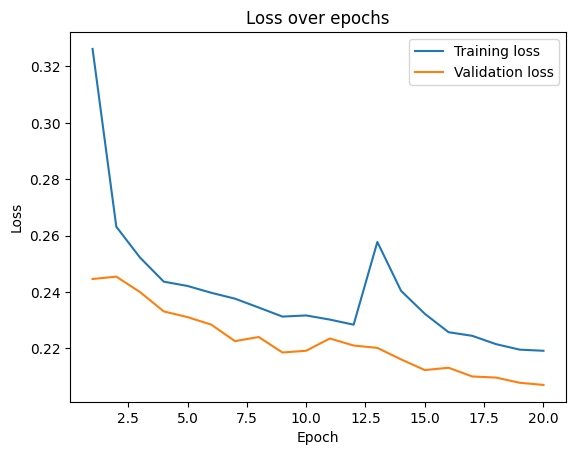

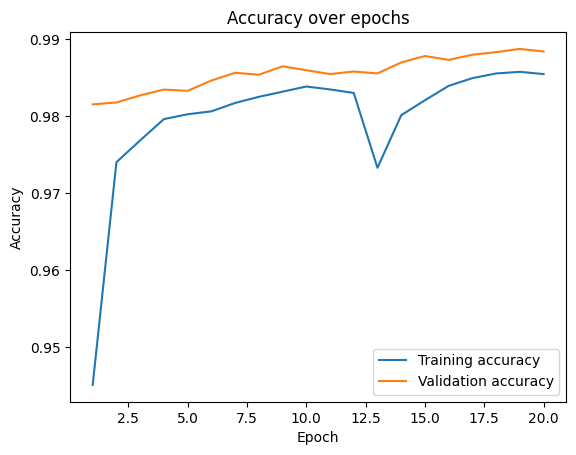

In [12]:
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras import callbacks

ai_model_directory = Path(base_project_directory) / "AI Model"
saved_models_directory = ai_model_directory / "models"
outputs_directory = ai_model_directory / "outputs"

saved_models_directory.mkdir(parents=True, exist_ok=True)
outputs_directory.mkdir(parents=True, exist_ok=True)

class_names_in_order = ["cats", "dogs", "unknown"]
number_of_classes = len(class_names_in_order)

expected_class_indices = {"cats": 0, "dogs": 1, "unknown": 2}
if train_data_gen.class_indices != expected_class_indices:
    raise RuntimeError(
        f"Unexpected class indices: {train_data_gen.class_indices}. "
        f"Expected: {expected_class_indices}"
    )

tf.keras.utils.set_random_seed(random_seed)

# Compute class weights from the training generator distribution.
train_class_counts = np.bincount(train_data_gen.classes, minlength=number_of_classes)
if np.any(train_class_counts == 0):
    raise RuntimeError(f"At least one class has 0 samples in training: {train_class_counts.tolist()}")

total_train_samples = int(train_class_counts.sum())
class_weight = {
    class_index: total_train_samples / (number_of_classes * int(class_count))
    for class_index, class_count in enumerate(train_class_counts)
}

print("Training samples:", total_train_samples)
print("Training class counts:", dict(zip(class_names_in_order, train_class_counts.tolist())))
print("Class weight:", class_weight)

# Build the model.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(image_height, image_width, 3),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

model_inputs = tf.keras.Input(shape=(image_height, image_width, 3))
preprocessed_inputs = tf.keras.applications.mobilenet_v2.preprocess_input(model_inputs * 255.0)
feature_maps = base_model(preprocessed_inputs, training=False)
pooled_features = tf.keras.layers.GlobalAveragePooling2D()(feature_maps)
pooled_features = tf.keras.layers.Dropout(0.3)(pooled_features)
hidden_features = tf.keras.layers.Dense(256, activation="relu")(pooled_features)
hidden_features = tf.keras.layers.Dropout(0.3)(hidden_features)
model_outputs = tf.keras.layers.Dense(number_of_classes, activation="softmax")(hidden_features)

model = tf.keras.Model(inputs=model_inputs, outputs=model_outputs)

loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

# Phase 1: feature extraction.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_function,
    metrics=["accuracy"],
)

early_stopping_callback = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    restore_best_weights=True,
)

learning_rate_scheduler = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1,
)

history_phase_1 = model.fit(
    train_data_gen,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping_callback, learning_rate_scheduler],
    class_weight=class_weight,
)

# Phase 2: fine tuning (unfreeze last N layers).
fine_tune_layers_to_unfreeze = 30
base_model.trainable = True
for layer in base_model.layers[:-fine_tune_layers_to_unfreeze]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=loss_function,
    metrics=["accuracy"],
)

early_stopping_callback_phase_2 = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=2,
    restore_best_weights=True,
)

learning_rate_scheduler_phase_2 = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1,
)

history_phase_2 = model.fit(
    train_data_gen,
    epochs=8,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping_callback_phase_2, learning_rate_scheduler_phase_2],
    class_weight=class_weight,
)

# Combine history (Phase 1 + Phase 2) so plots and exports are continuous.
combined_history = {}
for key in set(history_phase_1.history.keys()).union(set(history_phase_2.history.keys())):
    combined_history[key] = history_phase_1.history.get(key, []) + history_phase_2.history.get(key, [])

training_history_file_path = outputs_directory / "training_history_cell_a.json"
with open(training_history_file_path, "w", encoding="utf-8") as history_file:
    json.dump(combined_history, history_file, indent=2)
print("Saved training history to:", training_history_file_path)

class_indices_file_path = outputs_directory / "class_indices.json"
with open(class_indices_file_path, "w", encoding="utf-8") as class_file:
    json.dump(train_data_gen.class_indices, class_file, indent=2)
print("Saved class indices to:", class_indices_file_path)

training_loss_values = combined_history.get("loss", [])
validation_loss_values = combined_history.get("val_loss", [])
training_accuracy_values = combined_history.get("accuracy", [])
validation_accuracy_values = combined_history.get("val_accuracy", [])

epochs_ran = range(1, len(training_loss_values) + 1)

plt.figure()
plt.plot(epochs_ran, training_loss_values, label="Training loss")
plt.plot(epochs_ran, validation_loss_values, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_ran, training_accuracy_values, label="Training accuracy")
plt.plot(epochs_ran, validation_accuracy_values, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.legend()
plt.show()


## Tune the Unknown Confidence Threshold (Validation Only)

This section finds the best confidence threshold for forcing a prediction to `unknown` when the model is not confident enough.

It runs the trained model on the **validation split** to get softmax probabilities, then tests a range of thresholds (default `0.40` to `0.70` in steps of `0.01`). For each threshold it reports:

- How often real cats and dogs are rejected into `unknown`
- How often real `unknown` images are incorrectly accepted as cat or dog
- Accuracy on known classes (`cats + dogs`) and overall accuracy

The chosen threshold is the one that first satisfies all guardrails (`cat_reject <= 1%`, `dog_reject <= 1%`, `unknown_false_accept <= 10%`) and, among those, maximizes known-class accuracy (`cats + dogs`) with tie-breakers favoring lower unknown false accepts, then lower cat/dog rejects.

All threshold results are stored, then the script prints the **top 10 thresholds** and returns the chosen threshold to be reused unchanged for the final test evaluation.


In [13]:
import numpy as np
from math import ceil
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Force "unknown" if max probability is below the confidence threshold.
def apply_unknown_threshold(
    probabilities: np.ndarray,
    confidence_threshold: float,
    unknown_class_index: int,
) -> np.ndarray:
    probabilities = np.asarray(probabilities)

    if probabilities.ndim != 2:
        raise ValueError(f"probabilities must be 2D (num_samples, num_classes). Got: {probabilities.shape}")

    maximum_probabilities = probabilities.max(axis=1)
    predicted_indices = probabilities.argmax(axis=1).astype(int)

    predicted_indices = np.where(
        maximum_probabilities < confidence_threshold,
        unknown_class_index,
        predicted_indices,
    )

    return predicted_indices


# Tune the confidence threshold using validation only, then freeze it for test.
def tune_best_confidence_threshold_on_validation(
    model,
    validation_split_directory,
    image_height: int,
    image_width: int,
    batch_size: int,
    threshold_values: list[float] | None = None,
    class_folder_names: list[str] | None = None,
    unknown_folder_name: str = "unknown",
    maximum_known_reject_rate: float = 0.01,
    maximum_unknown_false_accept_rate: float = 0.10,
    top_thresholds_to_show: int = 10,
) -> float:
    if threshold_values is None:
        threshold_values = [value / 100 for value in range(40, 71)]

    if class_folder_names is None:
        class_folder_names = ["cats", "dogs", "unknown"]

    validation_generator = ImageDataGenerator(rescale=1.0 / 255.0).flow_from_directory(
        directory=str(validation_split_directory),
        target_size=(image_height, image_width),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        classes=class_folder_names,
        shuffle=False,
    )

    if validation_generator.n == 0:
        raise ValueError("Validation directory contains 0 images, cannot tune threshold.")

    if unknown_folder_name not in validation_generator.class_indices:
        raise ValueError(
            f"Unknown folder '{unknown_folder_name}' not found. class_indices: {validation_generator.class_indices}"
        )

    if "cats" not in validation_generator.class_indices or "dogs" not in validation_generator.class_indices:
        raise ValueError(f"Expected 'cats' and 'dogs' folders. class_indices: {validation_generator.class_indices}")

    cat_class_index = int(validation_generator.class_indices["cats"])
    dog_class_index = int(validation_generator.class_indices["dogs"])
    unknown_class_index = int(validation_generator.class_indices[unknown_folder_name])

    true_indices = validation_generator.classes.astype(int)

    cat_mask = true_indices == cat_class_index
    dog_mask = true_indices == dog_class_index
    unknown_mask = true_indices == unknown_class_index
    known_mask = cat_mask | dog_mask

    total_steps = ceil(validation_generator.n / batch_size)

    print("\nPredicting probabilities on validation set...")
    print(f"Total validation images: {validation_generator.n}")
    print(f"Batch size: {batch_size}")
    print(f"Steps: {total_steps}")
    print(f"Class indices: {validation_generator.class_indices}\n")

    validation_probabilities = model.predict(
        validation_generator,
        steps=total_steps,
        verbose=1,
    )

    threshold_results: list[dict] = []

    print("\nthreshold | cat_reject% | dog_reject% | unk_false_accept% | unk_recall% | known_acc% | overall_acc%")
    print("--------- | ---------- | ---------- | ---------------- | ---------- | --------- | -----------")

    for confidence_threshold in threshold_values:
        predicted_indices = apply_unknown_threshold(
            probabilities=validation_probabilities,
            confidence_threshold=confidence_threshold,
            unknown_class_index=unknown_class_index,
        )

        cat_reject_rate = float(np.mean(predicted_indices[cat_mask] == unknown_class_index)) if np.any(cat_mask) else 0.0
        dog_reject_rate = float(np.mean(predicted_indices[dog_mask] == unknown_class_index)) if np.any(dog_mask) else 0.0
        known_reject_sum = cat_reject_rate + dog_reject_rate

        unknown_false_accept_rate = float(
            np.mean(predicted_indices[unknown_mask] != unknown_class_index)
        ) if np.any(unknown_mask) else 0.0
        unknown_recall = 1.0 - unknown_false_accept_rate if np.any(unknown_mask) else 0.0

        known_accuracy = float(
            np.mean(predicted_indices[known_mask] == true_indices[known_mask])
        ) if np.any(known_mask) else 0.0
        overall_accuracy = float(np.mean(predicted_indices == true_indices))

        meets_known_reject_constraint = (cat_reject_rate <= maximum_known_reject_rate) and (
            dog_reject_rate <= maximum_known_reject_rate
        )
        meets_unknown_accept_constraint = unknown_false_accept_rate <= maximum_unknown_false_accept_rate
        meets_constraints = bool(meets_known_reject_constraint and meets_unknown_accept_constraint)

        threshold_results.append(
            {
                "threshold": float(confidence_threshold),
                "cat_reject_rate": float(cat_reject_rate),
                "dog_reject_rate": float(dog_reject_rate),
                "known_reject_sum": float(known_reject_sum),
                "unknown_false_accept_rate": float(unknown_false_accept_rate),
                "unknown_recall": float(unknown_recall),
                "known_accuracy": float(known_accuracy),
                "overall_accuracy": float(overall_accuracy),
                "meets_constraints": meets_constraints,
            }
        )

        print(
            f"{confidence_threshold:8.2f} |"
            f"{cat_reject_rate*100:10.2f} |"
            f"{dog_reject_rate*100:10.2f} |"
            f"{unknown_false_accept_rate*100:16.2f} |"
            f"{unknown_recall*100:10.2f} |"
            f"{known_accuracy*100:9.2f} |"
            f"{overall_accuracy*100:11.2f}"
        )

    eligible_results = [row for row in threshold_results if row["meets_constraints"]]

    def sort_key_for_constraints(row: dict) -> tuple:
        return (
            -row["known_accuracy"],
            row["unknown_false_accept_rate"],
            row["known_reject_sum"],
            -row["overall_accuracy"],
        )

    if eligible_results:
        eligible_results_sorted = sorted(eligible_results, key=sort_key_for_constraints)
        best_row = eligible_results_sorted[0]

        print(f"\nTop {min(top_thresholds_to_show, len(eligible_results_sorted))} thresholds that meet constraints")
        for index, row in enumerate(eligible_results_sorted[:top_thresholds_to_show], start=1):
            print(
                f"{index:2d}. threshold={row['threshold']:.2f} | "
                f"known_acc={row['known_accuracy']*100:.2f}% | "
                f"unk_false_accept={row['unknown_false_accept_rate']*100:.2f}% | "
                f"cat_reject={row['cat_reject_rate']*100:.2f}% | "
                f"dog_reject={row['dog_reject_rate']*100:.2f}% | "
                f"overall_acc={row['overall_accuracy']*100:.2f}%"
            )

        print("\nChosen threshold (validation only):", f"{best_row['threshold']:.2f}")
        print("Known accuracy (cats+dogs only):", f"{best_row['known_accuracy']*100:.2f}%")
        print("Unknown false accept rate:", f"{best_row['unknown_false_accept_rate']*100:.2f}%")
        return float(best_row["threshold"])

    known_reject_weight = 2.0
    unknown_false_accept_weight = 3.0

    for row in threshold_results:
        average_known_reject_rate = (row["cat_reject_rate"] + row["dog_reject_rate"]) / 2.0
        row["fallback_score"] = (
            row["known_accuracy"]
            - unknown_false_accept_weight * row["unknown_false_accept_rate"]
            - known_reject_weight * average_known_reject_rate
        )

    threshold_results_sorted = sorted(threshold_results, key=lambda row: row["fallback_score"], reverse=True)
    best_row = threshold_results_sorted[0]

    print("\nNo threshold met both constraints.")
    print(f"\nTop {min(top_thresholds_to_show, len(threshold_results_sorted))} thresholds by fallback score")
    for index, row in enumerate(threshold_results_sorted[:top_thresholds_to_show], start=1):
        print(
            f"{index:2d}. threshold={row['threshold']:.2f} | "
            f"score={row['fallback_score']:.6f} | "
            f"known_acc={row['known_accuracy']*100:.2f}% | "
            f"unk_false_accept={row['unknown_false_accept_rate']*100:.2f}% | "
            f"cat_reject={row['cat_reject_rate']*100:.2f}% | "
            f"dog_reject={row['dog_reject_rate']*100:.2f}% | "
            f"overall_acc={row['overall_accuracy']*100:.2f}%"
        )

    print("\nFallback chosen threshold (validation only):", f"{best_row['threshold']:.2f}")
    print("Tip: loosen maximum_known_reject_rate or maximum_unknown_false_accept_rate slightly if you want a constrained solution.")
    return float(best_row["threshold"])


chosen_threshold = tune_best_confidence_threshold_on_validation(
    model=model,
    validation_split_directory=validation_split_directory,
    image_height=image_height,
    image_width=image_width,
    batch_size=batch_size,
    maximum_known_reject_rate=0.01,
    maximum_unknown_false_accept_rate=0.10,
    top_thresholds_to_show=10,
)

print("\nReturned threshold:", chosen_threshold)


Found 11936 images belonging to 3 classes.

Predicting probabilities on validation set...
Total validation images: 11936
Batch size: 32
Steps: 373
Class indices: {'cats': 0, 'dogs': 1, 'unknown': 2}

373/373 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step

threshold | cat_reject% | dog_reject% | unk_false_accept% | unk_recall% | known_acc% | overall_acc%
--------- | ---------- | ---------- | ---------------- | ---------- | --------- | -----------
    0.40 |      0.26 |      0.56 |            1.05 |     98.95 |    98.71 |      98.84
    0.41 |      0.26 |      0.56 |            1.05 |     98.95 |    98.71 |      98.84
    0.42 |      0.26 |      0.56 |            1.05 |     98.95 |    98.71 |      98.84
    0.43 |      0.26 |      0.56 |            1.05 |     98.95 |    98.71 |      98.84
    0.44 |      0.26 |      0.56 |            1.04 |     98.96 |    98.71 |      98.85
    0.45 |      0.26 |      0.56 |            1.04 |     98.96 |    98.71 |      98.85
    0.46 |      0.26 |      0.56 |     

## Final Training Run (Train + Validation Combined)

This section produces the single final model for the project.

It uses the best epoch counts found during training in the first training step and the frozen confidence threshold tuned on validation only from the previous cell. Then it combines the train split and validation split into one larger training set and retrains the model in two phases:

- **Phase 1 (feature extraction):** MobileNetV2 stays frozen and only the new classification head is trained.
- **Phase 2 (fine-tuning):** the last **about 30 layers** of MobileNetV2 are unfrozen and trained with a lower learning rate.

The number of epochs for each final-training phase is chosen from the first training run by taking the epoch where validation loss is lowest in that same phase.

At the end, it saves the final `.keras` model plus the frozen threshold so the same decision rule is used for testing and in the web app.


In [15]:
import json
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow.keras import callbacks


# This cell assumes these already exist from earlier cells:
# - train_split_directory, validation_split_directory
# - image_height, image_width, batch_size, random_seed
# - history_phase_1, history_phase_2 (from training cell)
# - chosen_threshold (from threshold tuning cell)

required_variable_names = [
    "train_split_directory",
    "validation_split_directory",
    "image_height",
    "image_width",
    "batch_size",
    "random_seed",
    "history_phase_1",
    "history_phase_2",
    "chosen_threshold",
    "base_project_directory",
]
missing_variable_names = [name for name in required_variable_names if name not in globals()]
if missing_variable_names:
    raise RuntimeError("Missing required variables: " + ", ".join(missing_variable_names))


class_names_in_order = ["cats", "dogs", "unknown"]
number_of_classes = len(class_names_in_order)

phase_1_validation_losses = history_phase_1.history.get("val_loss", [])
phase_2_validation_losses = history_phase_2.history.get("val_loss", [])
if not phase_1_validation_losses or not phase_2_validation_losses:
    raise RuntimeError("First training cells histories must contain 'val_loss' so epochs can be selected reproducibly.")

phase_1_epochs_to_train = int(np.argmin(phase_1_validation_losses)) + 1
phase_2_epochs_to_train = int(np.argmin(phase_2_validation_losses)) + 1

print("Final training plan (train + validation combined)")
print(f"  Phase 1 epochs (best val_loss epoch from first training cell): {phase_1_epochs_to_train}")
print(f"  Phase 2 epochs (best val_loss epoch from first training cell): {phase_2_epochs_to_train}")
print(f"  Frozen threshold (from threshold tuning cell, validation only): {float(chosen_threshold):.2f}")


# Create output folders for the final artifacts.
ai_model_directory = Path(base_project_directory) / "AI Model"
models_directory = ai_model_directory / "models"
outputs_directory = ai_model_directory / "outputs"
models_directory.mkdir(parents=True, exist_ok=True)
outputs_directory.mkdir(parents=True, exist_ok=True)

final_model_file_path = models_directory / "cat_dog_unknown_classifier.keras"
frozen_threshold_file_path = outputs_directory / "frozen_threshold.json"
final_training_history_file_path = outputs_directory / "final_training_history.json"


# Build one combined dataset from the existing train and validation folders.
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=str(train_split_directory),
    labels="inferred",
    label_mode="categorical",
    class_names=class_names_in_order,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=True,
    seed=random_seed,
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=str(validation_split_directory),
    labels="inferred",
    label_mode="categorical",
    class_names=class_names_in_order,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=True,
    seed=random_seed,
)

combined_training_dataset = train_dataset.concatenate(validation_dataset)
combined_training_dataset = combined_training_dataset.prefetch(tf.data.AUTOTUNE)

print("\nCombined training data ready")
print(f"  Train folder:      {train_split_directory}")
print(f"  Validation folder: {validation_split_directory}")
print("  Class order:", class_names_in_order)


# Keep final training reproducible.
tf.keras.utils.set_random_seed(random_seed)


# Data augmentation for the final training run.
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(30 / 360),
        tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15),
        tf.keras.layers.RandomZoom(0.15),
    ]
)


def preprocess_for_training(images, labels):
    # Scale to [0, 1], then apply augmentation similar to your generator setup.
    images = tf.cast(images, tf.float32) / 255.0
    images = data_augmentation(images, training=True)
    images = tf.image.random_brightness(images, max_delta=0.1)
    return images, labels


combined_training_dataset = (
    combined_training_dataset
    .map(preprocess_for_training, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


# Rebuild the same model recipe, then train once on the combined dataset.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(image_height, image_width, 3),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

model_inputs = tf.keras.Input(shape=(image_height, image_width, 3))
preprocessed_inputs = tf.keras.applications.mobilenet_v2.preprocess_input(model_inputs * 255.0)
feature_maps = base_model(preprocessed_inputs, training=False)
pooled_features = tf.keras.layers.GlobalAveragePooling2D()(feature_maps)
dropped_features = tf.keras.layers.Dropout(0.3)(pooled_features)
hidden_features = tf.keras.layers.Dense(256, activation="relu")(dropped_features)
hidden_features = tf.keras.layers.Dropout(0.3)(hidden_features)
model_outputs = tf.keras.layers.Dense(number_of_classes, activation="softmax")(hidden_features)

model = tf.keras.Model(inputs=model_inputs, outputs=model_outputs)

loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)


# Phase 1, feature extraction only.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_function,
    metrics=["accuracy"],
)

learning_rate_scheduler_phase_1 = callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1,
)

history_final_phase_1 = model.fit(
    combined_training_dataset,
    epochs=phase_1_epochs_to_train,
    callbacks=[learning_rate_scheduler_phase_1],
)


# Phase 2, fine tuning by unfreezing the last part of MobileNetV2.
fine_tune_layers_to_unfreeze = 30
base_model.trainable = True
for layer in base_model.layers[:-fine_tune_layers_to_unfreeze]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=loss_function,
    metrics=["accuracy"],
)

learning_rate_scheduler_phase_2 = callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1,
)

history_final_phase_2 = model.fit(
    combined_training_dataset,
    epochs=phase_2_epochs_to_train,
    callbacks=[learning_rate_scheduler_phase_2],
)


# Save the final model and the frozen threshold for test evaluation and the web app.
model.save(final_model_file_path)
print("\nSaved final model to:", final_model_file_path)

with open(frozen_threshold_file_path, "w", encoding="utf-8") as threshold_file:
    json.dump({"chosen_threshold": float(chosen_threshold)}, threshold_file, indent=2)
print("Saved frozen threshold to:", frozen_threshold_file_path)

final_training_history = {
    "phase_1": history_final_phase_1.history,
    "phase_2": history_final_phase_2.history,
    "phase_1_epochs_trained": phase_1_epochs_to_train,
    "phase_2_epochs_trained": phase_2_epochs_to_train,
    "fine_tune_layers_to_unfreeze": fine_tune_layers_to_unfreeze,
    "class_names_in_order": class_names_in_order,
}

with open(final_training_history_file_path, "w", encoding="utf-8") as history_file:
    json.dump(final_training_history, history_file, indent=2)
print("Saved final training history to:", final_training_history_file_path)


Final training plan (train + validation combined)
  Phase 1 epochs (best val_loss epoch from first training cell): 9
  Phase 2 epochs (best val_loss epoch from first training cell): 8
  Frozen threshold (from threshold tuning cell, validation only): 0.46
Found 47738 files belonging to 3 classes.
Found 11936 files belonging to 3 classes.

Combined training data ready
  Train folder:      C:\Users\223023795\Desktop\Cat and Dog Classifier\Datasets\Splits\train_split
  Validation folder: C:\Users\223023795\Desktop\Cat and Dog Classifier\Datasets\Splits\validation_split
  Class order: ['cats', 'dogs', 'unknown']
Epoch 1/9
1865/1865 ━━━━━━━━━━━━━━━━━━━━ 288s 153ms/step - accuracy: 0.9515 - loss: 0.3083 - learning_rate: 1.0000e-04
Epoch 2/9
1865/1865 ━━━━━━━━━━━━━━━━━━━━ 295s 158ms/step - accuracy: 0.9742 - loss: 0.2532 - learning_rate: 1.0000e-04
Epoch 3/9
1865/1865 ━━━━━━━━━━━━━━━━━━━━ 297s 159ms/step - accuracy: 0.9761 - loss: 0.2458 - learning_rate: 1.0000e-04
Epoch 4/9
1865/1865 ━━━━━━━━

## Final Test Evaluation on Holdout Datasets

This section evaluates the **final trained model** using your **held-out test folders**.

It loads the saved model and the frozen confidence threshold (chosen using validation only), then:

- Runs **Oxford cats and dogs test** (`Datasets/Test/oxford_test`) to measure cats vs dogs performance, including how often real cats or dogs get rejected as **unknown** after applying the threshold.
- Runs **unknown test sets** (`Datasets/Test/unknown_test/unknown_places` and `unknown_coco`) to measure how well the model routes non-cat/dog images to the **unknown** class after applying the same frozen threshold.
- Prints an official **confusion matrix** at the end for the Oxford test (true cats and dogs vs predicted cats, dogs, unknown).


In [18]:
import json
from pathlib import Path

import numpy as np
import tensorflow as tf


# This cell assumes these already exist from earlier cells:
# base_project_directory, image_height, image_width, batch_size, random_seed
required_variable_names = ["base_project_directory", "image_height", "image_width", "batch_size", "random_seed"]
missing_variable_names = [name for name in required_variable_names if name not in globals()]
if missing_variable_names:
    raise RuntimeError("Missing required variables: " + ", ".join(missing_variable_names))


class_names_in_order = ["cats", "dogs", "unknown"]
unknown_class_index = 2

datasets_test_directory = Path(base_project_directory) / "Datasets" / "Test"
oxford_test_directory = datasets_test_directory / "oxford_test"
unknown_test_directory = datasets_test_directory / "unknown_test"
unknown_places_test_directory = unknown_test_directory / "unknown_places"
unknown_coco_test_directory = unknown_test_directory / "unknown_coco"

ai_model_directory = Path(base_project_directory) / "AI Model"
saved_models_directory = globals().get("saved_models_directory", ai_model_directory / "models")
outputs_directory = globals().get("outputs_directory", ai_model_directory / "outputs")

final_model_file_path = saved_models_directory / "cat_dog_unknown_classifier.keras"
frozen_threshold_file_path = outputs_directory / "frozen_threshold.json"


def apply_unknown_threshold(probabilities: np.ndarray, confidence_threshold: float) -> np.ndarray:
    probabilities = np.asarray(probabilities)

    if probabilities.ndim != 2:
        raise ValueError(f"probabilities must be 2D (num_samples, num_classes). Got: {probabilities.shape}")

    maximum_probabilities = probabilities.max(axis=1)
    predicted_indices = probabilities.argmax(axis=1).astype(int)

    predicted_indices = np.where(
        maximum_probabilities < confidence_threshold,
        unknown_class_index,
        predicted_indices,
    )
    return predicted_indices


def load_frozen_threshold(threshold_file_path: Path) -> float:
    if not threshold_file_path.exists():
        raise RuntimeError(f"Frozen threshold file not found: {threshold_file_path}")

    with open(threshold_file_path, "r", encoding="utf-8") as threshold_file:
        threshold_payload = json.load(threshold_file)

    if "chosen_threshold" not in threshold_payload:
        raise RuntimeError(f"Expected 'chosen_threshold' key in: {threshold_file_path}")

    return float(threshold_payload["chosen_threshold"])


def build_scaled_labeled_dataset(directory_path: Path, class_names: list[str]) -> tf.data.Dataset:
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory=str(directory_path),
        labels="inferred",
        label_mode="int",
        class_names=class_names,
        image_size=(image_height, image_width),
        batch_size=batch_size,
        shuffle=False,
    )

    def scale_images(images, labels):
        images = tf.cast(images, tf.float32) / 255.0
        return images, labels

    return dataset.map(scale_images, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


def build_scaled_unlabeled_dataset(directory_path: Path) -> tf.data.Dataset:
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory=str(directory_path),
        labels=None,
        image_size=(image_height, image_width),
        batch_size=batch_size,
        shuffle=False,
    )

    def scale_images(images):
        images = tf.cast(images, tf.float32) / 255.0
        return images

    return dataset.map(scale_images, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


def collect_true_labels(labeled_dataset: tf.data.Dataset) -> np.ndarray:
    labels_batches = []
    for _, labels in labeled_dataset:
        labels_batches.append(labels.numpy())
    return np.concatenate(labels_batches, axis=0).astype(int)


def compute_oxford_metrics(true_labels: np.ndarray, predicted_labels: np.ndarray) -> dict:
    true_labels = true_labels.astype(int)
    predicted_labels = predicted_labels.astype(int)

    cats_mask = true_labels == 0
    dogs_mask = true_labels == 1
    known_mask = cats_mask | dogs_mask

    overall_accuracy = float(np.mean(predicted_labels == true_labels)) if len(true_labels) else 0.0
    rejected_as_unknown_rate = float(np.mean(predicted_labels == unknown_class_index)) if len(true_labels) else 0.0

    cat_recall = float(np.mean(predicted_labels[cats_mask] == 0)) if np.any(cats_mask) else 0.0
    dog_recall = float(np.mean(predicted_labels[dogs_mask] == 1)) if np.any(dogs_mask) else 0.0

    cats_rejected_as_unknown = float(np.mean(predicted_labels[cats_mask] == unknown_class_index)) if np.any(cats_mask) else 0.0
    dogs_rejected_as_unknown = float(np.mean(predicted_labels[dogs_mask] == unknown_class_index)) if np.any(dogs_mask) else 0.0

    known_accuracy = float(np.mean(predicted_labels[known_mask] == true_labels[known_mask])) if np.any(known_mask) else 0.0

    return {
        "total_images": int(len(true_labels)),
        "accuracy_unknown_counted_wrong": overall_accuracy,
        "known_only_accuracy": known_accuracy,
        "rejected_as_unknown_rate": rejected_as_unknown_rate,
        "cat_recall": cat_recall,
        "dog_recall": dog_recall,
        "cats_rejected_as_unknown": cats_rejected_as_unknown,
        "dogs_rejected_as_unknown": dogs_rejected_as_unknown,
    }


def compute_unknown_test_metrics(predicted_labels: np.ndarray) -> dict:
    predicted_labels = predicted_labels.astype(int)
    total_images = int(len(predicted_labels))

    if total_images == 0:
        return {
            "total_images": 0,
            "predicted_unknown_rate": 0.0,
            "false_accept_rate_predicted_cat_or_dog": 0.0,
            "predicted_cats_rate": 0.0,
            "predicted_dogs_rate": 0.0,
        }

    predicted_unknown_rate = float(np.mean(predicted_labels == unknown_class_index))
    predicted_cats_rate = float(np.mean(predicted_labels == 0))
    predicted_dogs_rate = float(np.mean(predicted_labels == 1))
    false_accept_rate = float(np.mean((predicted_labels == 0) | (predicted_labels == 1)))

    return {
        "total_images": total_images,
        "predicted_unknown_rate": predicted_unknown_rate,
        "false_accept_rate_predicted_cat_or_dog": false_accept_rate,
        "predicted_cats_rate": predicted_cats_rate,
        "predicted_dogs_rate": predicted_dogs_rate,
    }


def compute_confusion_matrix_2x3(true_labels: np.ndarray, predicted_labels: np.ndarray) -> np.ndarray:
    matrix = np.zeros((2, 3), dtype=int)

    for true_value, predicted_value in zip(true_labels.tolist(), predicted_labels.tolist(), strict=False):
        if true_value not in (0, 1):
            continue
        if predicted_value not in (0, 1, 2):
            continue
        matrix[true_value, predicted_value] += 1

    return matrix


if not final_model_file_path.exists():
    raise RuntimeError(f"Final model file not found: {final_model_file_path}")

chosen_threshold = load_frozen_threshold(frozen_threshold_file_path)
print(f"Using frozen threshold from validation: {chosen_threshold:.2f}")

model = tf.keras.models.load_model(final_model_file_path)


# Oxford cats and dogs holdout
oxford_dataset = build_scaled_labeled_dataset(
    directory_path=oxford_test_directory,
    class_names=["cats", "dogs"],
)
oxford_true_labels = collect_true_labels(oxford_dataset)
oxford_probabilities = model.predict(oxford_dataset, verbose=1)
oxford_predicted_labels = apply_unknown_threshold(probabilities=oxford_probabilities, confidence_threshold=chosen_threshold)

oxford_metrics = compute_oxford_metrics(true_labels=oxford_true_labels, predicted_labels=oxford_predicted_labels)
confusion_matrix_2x3 = compute_confusion_matrix_2x3(
    true_labels=oxford_true_labels,
    predicted_labels=oxford_predicted_labels,
)

cats_total = int(np.sum(oxford_true_labels == 0))
dogs_total = int(np.sum(oxford_true_labels == 1))
total_images = int(len(oxford_true_labels))

cats_predicted_as_cats = int(confusion_matrix_2x3[0, 0])
cats_predicted_as_dogs = int(confusion_matrix_2x3[0, 1])
cats_predicted_as_unknown = int(confusion_matrix_2x3[0, 2])
dogs_predicted_as_cats = int(confusion_matrix_2x3[1, 0])
dogs_predicted_as_dogs = int(confusion_matrix_2x3[1, 1])
dogs_predicted_as_unknown = int(confusion_matrix_2x3[1, 2])

predicted_cats_total = int(np.sum(oxford_predicted_labels == 0))
predicted_dogs_total = int(np.sum(oxford_predicted_labels == 1))
predicted_unknown_total = int(np.sum(oxford_predicted_labels == 2))

accepted_count = predicted_cats_total + predicted_dogs_total
accepted_rate = (accepted_count / total_images) if total_images else 0.0
accuracy_among_accepted = (
    (cats_predicted_as_cats + dogs_predicted_as_dogs) / accepted_count
    if accepted_count
    else 0.0
)
balanced_accuracy = (oxford_metrics["cat_recall"] + oxford_metrics["dog_recall"]) / 2.0

cat_precision = (cats_predicted_as_cats / predicted_cats_total) if predicted_cats_total else 0.0
dog_precision = (dogs_predicted_as_dogs / predicted_dogs_total) if predicted_dogs_total else 0.0
cat_f1 = (
    (2.0 * cat_precision * oxford_metrics["cat_recall"]) / (cat_precision + oxford_metrics["cat_recall"])
    if (cat_precision + oxford_metrics["cat_recall"]) > 0
    else 0.0
)
dog_f1 = (
    (2.0 * dog_precision * oxford_metrics["dog_recall"]) / (dog_precision + oxford_metrics["dog_recall"])
    if (dog_precision + oxford_metrics["dog_recall"]) > 0
    else 0.0
)
macro_f1 = (cat_f1 + dog_f1) / 2.0

print("\nOxford holdout results (cats/dogs only):")
print(f"Threshold: {chosen_threshold:.2f}")
print(f"Total images: {total_images}")
print(f"Accuracy (unknown counted as wrong): {oxford_metrics['accuracy_unknown_counted_wrong']*100:.2f} %")
print(f"Rejected as unknown rate: {oxford_metrics['rejected_as_unknown_rate']*100:.2f} %")
print(f"Cat recall: {oxford_metrics['cat_recall']*100:.2f} %")
print(f"Dog recall: {oxford_metrics['dog_recall']*100:.2f} %")
print(f"Cats rejected as unknown: {oxford_metrics['cats_rejected_as_unknown']*100:.2f} %")
print(f"Dogs rejected as unknown: {oxford_metrics['dogs_rejected_as_unknown']*100:.2f} %")

print("\nConfusion matrix (rows=true, cols=pred):")
print("                cats      dogs   unknown")
print(f"true cats     {cats_predicted_as_cats:8d}  {cats_predicted_as_dogs:8d}  {cats_predicted_as_unknown:8d}")
print(f"true dogs     {dogs_predicted_as_cats:8d}  {dogs_predicted_as_dogs:8d}  {dogs_predicted_as_unknown:8d}")

print("\nBreakdown by true class:")
print(
    f"True cats: {cats_total} | predicted cat: {cats_predicted_as_cats} ({(cats_predicted_as_cats / cats_total * 100) if cats_total else 0.0:.2f}%) | "
    f"predicted dog: {cats_predicted_as_dogs} ({(cats_predicted_as_dogs / cats_total * 100) if cats_total else 0.0:.2f}%) | "
    f"predicted unknown: {cats_predicted_as_unknown} ({(cats_predicted_as_unknown / cats_total * 100) if cats_total else 0.0:.2f}%)"
)
print(
    f"True dogs: {dogs_total} | predicted dog: {dogs_predicted_as_dogs} ({(dogs_predicted_as_dogs / dogs_total * 100) if dogs_total else 0.0:.2f}%) | "
    f"predicted cat: {dogs_predicted_as_cats} ({(dogs_predicted_as_cats / dogs_total * 100) if dogs_total else 0.0:.2f}%) | "
    f"predicted unknown: {dogs_predicted_as_unknown} ({(dogs_predicted_as_unknown / dogs_total * 100) if dogs_total else 0.0:.2f}%)"
)

print("\nTotals by predicted label:")
print(f"Predicted cats: {predicted_cats_total} ({(predicted_cats_total / total_images * 100) if total_images else 0.0:.2f}%)")
print(f"Predicted dogs: {predicted_dogs_total} ({(predicted_dogs_total / total_images * 100) if total_images else 0.0:.2f}%)")
print(f"Predicted unknown: {predicted_unknown_total} ({(predicted_unknown_total / total_images * 100) if total_images else 0.0:.2f}%)")

print("\nKey metrics (cats/dogs only truth):")
print(f"Overall accuracy (unknown counted as wrong): {oxford_metrics['accuracy_unknown_counted_wrong']*100:.2f}%")
print(f"Accepted rate (not unknown): {accepted_rate*100:.2f}%")
print(f"Accuracy among accepted only: {accuracy_among_accepted*100:.2f}%")
print(f"Balanced accuracy (avg cat+dog recall): {balanced_accuracy*100:.2f}%")

print("\nPer-class metrics:")
print(f"Cat precision: {cat_precision*100:.2f}% | Cat recall: {oxford_metrics['cat_recall']*100:.2f}% | Cat F1: {cat_f1*100:.2f}%")
print(f"Dog precision: {dog_precision*100:.2f}% | Dog recall: {oxford_metrics['dog_recall']*100:.2f}% | Dog F1: {dog_f1*100:.2f}%")
print(f"Macro F1: {macro_f1*100:.2f}%")

print("\nExact error counts:")
print(f"Cats predicted as dogs: {cats_predicted_as_dogs}")
print(f"Cats rejected as unknown: {cats_predicted_as_unknown}")
print(f"Dogs predicted as cats: {dogs_predicted_as_cats}")
print(f"Dogs rejected as unknown: {dogs_predicted_as_unknown}")


# Places unknown holdout
unknown_places_dataset = build_scaled_unlabeled_dataset(unknown_places_test_directory)
unknown_places_probabilities = model.predict(unknown_places_dataset, verbose=1)
unknown_places_predicted_labels = apply_unknown_threshold(
    probabilities=unknown_places_probabilities,
    confidence_threshold=chosen_threshold,
)
unknown_places_metrics = compute_unknown_test_metrics(unknown_places_predicted_labels)

print("\nPlaces unknown holdout results:")
print(f"Threshold: {chosen_threshold:.2f}")
print(f"Total images: {unknown_places_metrics['total_images']}")
print(f"Predicted unknown rate: {unknown_places_metrics['predicted_unknown_rate']*100:.2f} %")
print(f"Predicted cat rate: {unknown_places_metrics['predicted_cats_rate']*100:.2f} %")
print(f"Predicted dog rate: {unknown_places_metrics['predicted_dogs_rate']*100:.2f} %")


# COCO unknown holdout
unknown_coco_dataset = build_scaled_unlabeled_dataset(unknown_coco_test_directory)
unknown_coco_probabilities = model.predict(unknown_coco_dataset, verbose=1)
unknown_coco_predicted_labels = apply_unknown_threshold(
    probabilities=unknown_coco_probabilities,
    confidence_threshold=chosen_threshold,
)
unknown_coco_metrics = compute_unknown_test_metrics(unknown_coco_predicted_labels)

print("\nCOCO unknown holdout results:")
print(f"Threshold: {chosen_threshold:.2f}")
print(f"Total images: {unknown_coco_metrics['total_images']}")
print(f"Predicted unknown rate: {unknown_coco_metrics['predicted_unknown_rate']*100:.2f} %")
print(f"Predicted cat rate: {unknown_coco_metrics['predicted_cats_rate']*100:.2f} %")
print(f"Predicted dog rate: {unknown_coco_metrics['predicted_dogs_rate']*100:.2f} %")


Using frozen threshold from validation: 0.46
Found 7390 files belonging to 2 classes.
231/231 ━━━━━━━━━━━━━━━━━━━━ 62s 264ms/step

Oxford holdout results (cats/dogs only):
Threshold: 0.46
Total images: 7390
Accuracy (unknown counted as wrong): 98.23 %
Rejected as unknown rate: 0.49 %
Cat recall: 96.08 %
Dog recall: 99.26 %
Cats rejected as unknown: 0.92 %
Dogs rejected as unknown: 0.28 %

Confusion matrix (rows=true, cols=pred):
                cats      dogs   unknown
true cats         2306        72        22
true dogs           23      4953        14

Breakdown by true class:
True cats: 2400 | predicted cat: 2306 (96.08%) | predicted dog: 72 (3.00%) | predicted unknown: 22 (0.92%)
True dogs: 4990 | predicted dog: 4953 (99.26%) | predicted cat: 23 (0.46%) | predicted unknown: 14 (0.28%)

Totals by predicted label:
Predicted cats: 2329 (31.52%)
Predicted dogs: 5025 (68.00%)
Predicted unknown: 36 (0.49%)

Key metrics (cats/dogs only truth):
Overall accuracy (unknown counted as wrong): 